# Amazon Fine Food VoC–NPS Project

In [2]:
# Core imports & configuration 
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5)
%matplotlib inline

# Reproducibility
RANDOM_STATE = 42

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import LatentDirichletAllocation


In [4]:
#Step 1: Prepare a clean, consistent dataset that can be used for analysis and feature engineering. 数据清洗

# Function: load_reviews
# Purpose: Read the raw Amazon Fine Food dataset and prepare it for analysis
# Key actions:
#   - Keep only the relevant columns
#   - Convert timestamp to datetime
#   - Drop empty rows
#   - Deduplicate reviews
#   - Optionally downsample for faster experimentation


def load_reviews(csv_path: str, sample_size: int = None):
    df = pd.read_csv(csv_path)
    
    # Keep consistent columns
    keep_cols = [
        'Id','ProductId','UserId','ProfileName',
        'HelpfulnessNumerator','HelpfulnessDenominator',
        'Score','Time','Summary','Text'
    ]
    df = df[keep_cols]

    # Convert Time from unix to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')

    # Remove rows where both Summary and Text are missing
    df = df[~(df['Summary'].isna() & df['Text'].isna())] 

    # Deduplicate reviews at the user–product–time–summary level
    df = df.drop_duplicates(subset=['UserId','ProductId','Time','Summary'])

    # Optional: random sample for speed (useful if dataset is huge)
    if sample_size is not None and len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=RANDOM_STATE)
        
    #Reset row index (tidy DataFrame)
    return df.reset_index(drop=True)

# File path (local dataset from Kaggle)
CSV_PATH = "/Users/rgao58/Documents/Amazon Fine Food Reviews/Reviews.csv"  

# Load a sampled dataset (120k rows, faster to run)
df = load_reviews(CSV_PATH, sample_size=120000) 

# Quick sanity check: show first 3 rows + total size
print(df.head(3))
print(f"Loaded rows: {len(df):,}")


       Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   50889  B001RRAOA6  A1GG9T2DOVIRIS     keyclub                     0   
1  544493  B0011ZY61C  A35R32TA60XD57    M. Torma                     1   
2  143111  B000SDO5YQ   A5R3XOLGJG1P5      Amanda                     0   

   HelpfulnessDenominator  Score       Time                           Summary  \
0                       0      5 2011-11-07                         Love this   
1                       1      4 2011-09-09  Good food...questionable company   
2                       0      5 2012-10-26                  Wonderful taste!   

                                                Text  
0  Great product will order more.  Wish it didn't...  
1  I ordered some of the duck and venison food fo...  
2  Very pleased with the quality of the espresso....  
Loaded rows: 120,000


## Summary (Load & Clean Data):

In this step, I loaded the raw Amazon Fine Food Reviews CSV and do some basic cleaning so the data is usable.  

- Only keep the 10 important columns needed (Id, ProductId, UserId, ProfileName, helpful votes, score, time, summary, text).  
- Change the `Time` column from Unix numbers into real calendar dates.  
- Drop reviews that have no summary and no text at all.  
- Remove duplicate reviews (same user, product, time, and summary).  
- Take a random sample (120k rows) so analysis runs faster.  
- Reset the row index so the table is tidy.  

After Step 1, the dataset still has 10 columns, but it is much cleaner and ready for feature engineering.


In [6]:
# Step 2: Feature engineering (NPS, helpfulness, text merge, sentiment)
# Purpose: Transform raw reviews into structured features for analysis & modeling
# Key outputs:
#   - Helpful ratio (weights reviews by quality)
#   - NPS labels (Promoter / Passive / Detractor)
#   - Combined review text (Summary + Text)
#   - Simple text signals (length, exclamation count, caps ratio)
#   - CES proxy score (effort keywords vs easy keywords)
#   - Sentiment score (VADER compound polarity)

def add_quality_nps_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    
     # 1. Helpfulness ratio (numerator / denominator, clipped 0–1)
    denom = df['HelpfulnessDenominator'].replace(0, np.nan)
    df['helpful_ratio'] = (df['HelpfulnessNumerator'] / denom).clip(0,1).fillna(0.0)

    # 2. NPS label mapping (5–4 → promoter, 3 → passive, 1–2 → detractor)
    def label_nps(score: int) -> str:
        if score >= 4:  return 'promoter'
        elif score == 3: return 'passive'
        else:            return 'detractor' 
    df['nps_label'] = df['Score'].apply(label_nps)

     # 3. Merge summary + text into one field
    df['text_all'] = (df['Summary'].fillna('') + ' ' + df['Text'].fillna('')).str.strip()

    # 4. Simple text-based numeric features
    df['text_len']   = df['text_all'].str.len().fillna(0)   # review length
    df['exclaim_cnt']= df['text_all'].str.count('!')      # count of exclamation marks

    def caps_ratio(s: str) -> float:
        if not isinstance(s, str) or len(s) == 0: return 0.0
        letters = [ch for ch in s if ch.isalpha()]
        if len(letters) == 0: return 0.0
        caps = sum(1 for ch in letters if ch.isupper())
        return caps / len(letters)
    df['caps_ratio'] = df['text_all'].apply(caps_ratio)   # ratio of capital letters

     # 5. CES (Customer Effort Score) proxy via keywords
    difficult_kw = ['hard','difficult','complicated','confusing','annoying','frustrating','problem','issue','tough','effort','return','refund','broken']
    easy_kw      = ['easy','simple','straightforward','quick','fast']
    def kw_score(s: str, kws: list) -> int:
        if not isinstance(s, str): return 0
        s_low = s.lower()
        return sum(s_low.count(k) for k in kws)
    df['ces_difficult'] = df['text_all'].apply(lambda s: kw_score(s, difficult_kw))
    df['ces_easy']      = df['text_all'].apply(lambda s: kw_score(s, easy_kw))
    df['ces_score']     = df['ces_difficult'] - df['ces_easy']      # higher = more effort

    return df

def add_vader_sentiment(df: pd.DataFrame) -> pd.DataFrame:
    try:
        from nltk.sentiment import SentimentIntensityAnalyzer
        sia = SentimentIntensityAnalyzer()
        # Compound sentiment score (-1 very negative, +1 very positive)
        df['sent_vader'] = df['text_all'].fillna('').apply(lambda s: sia.polarity_scores(s)['compound'])
    except Exception as e:
        print("VADER sentiment failed (did you download the lexicon?). Filling with 0. Error:", e)
        # Tip: run once in a cell → import nltk; nltk.download('vader_lexicon')
        df['sent_vader'] = 0.0
    return df

# Apply feature engineering functions
df = add_quality_nps_features(df)
df = add_vader_sentiment(df)

# Preview first few rows
df.head(3)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpful_ratio,nps_label,text_all,text_len,exclaim_cnt,caps_ratio,ces_difficult,ces_easy,ces_score,sent_vader
0,50889,B001RRAOA6,A1GG9T2DOVIRIS,keyclub,0,0,5,2011-11-07,Love this,Great product will order more. Wish it didn't...,0.0,promoter,Love this Great product will order more. Wish...,123,0,0.030928,0,0,0,0.9124
1,544493,B0011ZY61C,A35R32TA60XD57,M. Torma,1,1,4,2011-09-09,Good food...questionable company,I ordered some of the duck and venison food fo...,1.0,promoter,Good food...questionable company I ordered som...,1067,1,0.023895,1,0,1,0.9651
2,143111,B000SDO5YQ,A5R3XOLGJG1P5,Amanda,0,0,5,2012-10-26,Wonderful taste!,Very pleased with the quality of the espresso....,0.0,promoter,Wonderful taste! Very pleased with the quality...,261,1,0.019139,1,0,1,0.1742


## Summary (Feature Engineering):

In this step, I created extra columns from the raw reviews so I can analyze customer satisfaction more easily.  

- **helpful_ratio** → how many people voted the review as “helpful” (review quality).  
- **nps_label** → turns the 1–5 score into NPS groups: promoter (4–5), passive (3), detractor (1–2).  
- **text_all** → Merged field of Summary + Text  
- **text_len / exclaim_cnt / caps_ratio** → Character count of the review / Number of exclamation marks !/ Ratio of uppercase letters to all letters. (shows strong emotion，e.g., “LOVE IT!!!”).  
- **ces_difficult / ces_easy / ces_score** → Count of “effortful” keywords (hard, difficult, refund, broken, etc.) / Count of “easy” keywords (easy, simple, quick, fast). / ces_difficult – ces_easy， 	Positive = more complaints about difficulty; negative = more positive about ease

- **sent_vader** → automatic sentiment score (-1 = very negative, +1 = very positi， near 0 = neutralve).  

After Step 2, the dataset is no longer just raw reviews — it now has extra signals (quality, NPS, effort, emotion, sentiment) that make later analysis and visualization much more powerful.




In [7]:
#Step 3: Metrics (best-practice, fast & robust) + Plot helper 指标

from typing import Dict, Optional

# Winsorize numeric series to limit extreme values (1st–99th percentile).
def _winsorize_series(s: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.Series:
    if s.empty: return s
    low  = s.quantile(lower_q)
    high = s.quantile(upper_q)
    return s.clip(lower=low, upper=high)

# NPS with optional helpfulness weighting.
# NPS = (weighted_promoters - weighted_detractors) / total_weight * 100
def _weighted_nps_from_flags(df: pd.DataFrame) -> float:
    if df.empty: return np.nan
    w = df.get('helpful_ratio', pd.Series(1.0, index=df.index)).fillna(1.0)
    promoters  = ((df['nps_label'] == 'promoter').astype(int)  * w).sum()
    detractors = ((df['nps_label'] == 'detractor').astype(int) * w).sum()
    total = w.sum()
    if total == 0: return np.nan
    return (promoters - detractors) / total * 100.0

# Produce robust overall, monthly, and product-level NPS/CSAT with filters & smoothing.
def aggregate_metrics_best(
    df: pd.DataFrame,
    *,
    min_reviews_per_product: int = 30,
    min_reviews_per_month: int = 100,
    apply_winsorization: bool = True,
    winsor_lower_q: float = 0.01,
    winsor_upper_q: float = 0.99,
    rolling_window_months: Optional[int] = 3
) -> Dict[str, pd.Series]:
    d0 = df.copy()
    # Ensure clean helpful_ratio in [0,1]
    if 'helpful_ratio' not in d0.columns:
        d0['helpful_ratio'] = 1.0
    d0['helpful_ratio'] = d0['helpful_ratio'].fillna(1.0).clip(0,1) #Score_w is the version of Score used for CSAT averages. Ensure a clean helpful_ratio in [0, 1] (default to 1.0 if missing).

    # Robust CSAT (winsorized mean)
    d0['Score_w'] = d0['Score'].astype(float)
    if apply_winsorization:
        d0['Score_w'] = _winsorize_series(d0['Score_w'], winsor_lower_q, winsor_upper_q)  #Winsorization reduces the impact of extreme/erroneous ratings.

    res: Dict[str, pd.Series] = {}

    # Overall KPIs
    res['NPS_overall']  = _weighted_nps_from_flags(d0) #NPS_overall: helpfulness-weighted NPS across all reviews.
    res['CSAT_overall'] = d0['Score_w'].mean() #CSAT_overall: robust mean of scores (post-winsorization).

    # Monthly KPIs with volume filtering and optional smoothing
    d1 = d0.copy()
    d1['Time'] = pd.to_datetime(d1['Time'], errors='coerce')
    d1 = d1.dropna(subset=['Time'])  #Make sure Time is a valid datetime (drop invalids).
    if not d1.empty:
        d1['yyyymm'] = d1['Time'].dt.to_period('M').dt.to_timestamp()  #Create a month bucket yyyymm. 
        month_counts = d1.groupby('yyyymm').size()
        keep_months = month_counts[month_counts >= min_reviews_per_month].index  #Filter out sparse months (too few reviews → unreliable trend).
        d1 = d1[d1['yyyymm'].isin(keep_months)]
        
        if not d1.empty:
            month_agg = d1.groupby('yyyymm').apply(
                lambda g: pd.Series({'NPS': _weighted_nps_from_flags(g), 'CSAT': g['Score_w'].mean()})
            )  #For each month, compute NPS (weighted) and CSAT (winsorized mean).
            if rolling_window_months and rolling_window_months > 1:
                res['nps_by_month']  = month_agg['NPS'].rolling(rolling_window_months, min_periods=1).mean()
                res['csat_by_month'] = month_agg['CSAT'].rolling(rolling_window_months, min_periods=1).mean()
            else:
                res['nps_by_month']  = month_agg['NPS']
                res['csat_by_month'] = month_agg['CSAT']
        else:
            res['nps_by_month'] = pd.Series(dtype=float)
            res['csat_by_month'] = pd.Series(dtype=float)
    else:
        res['nps_by_month'] = pd.Series(dtype=float)
        res['csat_by_month'] = pd.Series(dtype=float)  #Optional smoothing: 3-month rolling average by default for cleaner trends.

    # Product-level KPIs with minimum volume filter
    d_prod = d0.copy()  #Drop products with too few reviews (reduces noise and ranking volatility).
    if min_reviews_per_product and min_reviews_per_product > 0:
        counts = d_prod.groupby('ProductId').size()
        keep_ids = counts[counts >= min_reviews_per_product].index
        d_prod = d_prod[d_prod['ProductId'].isin(keep_ids)]

    if not d_prod.empty:  #Compute NPS and CSAT per product and store as Series for ranking in Tableau/plots.
        prod_agg = d_prod.groupby('ProductId').apply(
            lambda g: pd.Series({'NPS': _weighted_nps_from_flags(g), 'CSAT': g['Score_w'].mean()})
        )
        res['nps_by_product']  = prod_agg['NPS'].dropna()
        res['csat_by_product'] = prod_agg['CSAT']
    else:
        res['nps_by_product']  = pd.Series(dtype=float)
        res['csat_by_product'] = pd.Series(dtype=float)

    return res

# Tiny helper to quickly visualize a time series (sanity checks)
def plot_series(series: pd.Series, title: str, ylabel: str):
    if series is None or len(series) == 0:
        print(f"[INFO] No data available for {title}.")
        return
    plt.figure()
    series.sort_index().plot()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

# Run aggregation with sensible defaults
metrics = aggregate_metrics_best(
    df,
    min_reviews_per_product=30,   # reduce noise in product rankings
    min_reviews_per_month=100,   # ensure stable monthly points
    apply_winsorization=True,   # robust CSAT averages
    rolling_window_months=3     # smooth monthly trends (3-mo MA)
)
print("Overall NPS:", metrics['NPS_overall'])
print("Overall CSAT:", metrics['CSAT_overall'])  #Prints the top-level overall metrics



Overall NPS: 65.59845909170113
Overall CSAT: 4.183925


## Summary (Metrics & Insights): 

I calculated two key customer metrics.

NPS is about +65, which is very strong. It means many more customers are happy promoters than unhappy detractors.

CSAT is about 4.18 out of 5, so most customers are satisfied.

The insight is: customers are generally happy, but some negative reviews still exist.
By looking at monthly numbers, we can see if satisfaction is going up or down over time.
By looking at products, we can find the top products customers love, and the weak products that cause problems.
This helps the company know what to continue doing well, and where to focus on improvements.



In [10]:
# Step 4: Model (Promoter vs Detractor) + Explainability
# Purpose:
#   - Train an explainable classifier to predict promoter (1) vs detractor (0)
#   - Use TF-IDF text + numeric VoC features
#   - Report test metrics and top positive/negative drivers

# 1 Prepare labeled data (drop passives)
def build_model_data(df: pd.DataFrame) -> pd.DataFrame:
    dff = df[df['nps_label'].isin(['promoter','detractor'])].copy()
    dff['target'] = (dff['nps_label'] == 'promoter').astype(int)
    return dff

# 2 Pipeline: TF-IDF for text + scaled numeric features + logistic regression
def build_pipeline() -> Pipeline:
    text_col = 'text_all'
    num_cols = ['helpful_ratio','text_len','exclaim_cnt','caps_ratio','ces_score','sent_vader']

    # TF-IDF: up to 30k features; 1–2 grams; English stopwords; ignore very rare terms (min_df=3)
    # StandardScaler(with_mean=False) is compatible with sparse matrices
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(max_features=30000,
                                      ngram_range=(1,2),
                                      stop_words='english',
                                      min_df=3),
             text_col),
            ('num', StandardScaler(with_mean=False), num_cols),
        ],
        remainder='drop'
    )

    # Fast, strong baseline; linear coefficients enable explainability
    clf = LogisticRegression(max_iter=1000)

    # End-to-end pipeline (clean training & inference)
    return Pipeline([('prep', preprocessor), ('clf', clf)])

# 3 Train/test split, fit, evaluate
def train_and_eval(dff: pd.DataFrame):
    features = ['text_all','helpful_ratio','text_len','exclaim_cnt','caps_ratio','ces_score','sent_vader']
    X = dff[features]
    y = dff['target']

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )

    pipe = build_pipeline()
    pipe.fit(X_tr, y_tr)

    y_pred = pipe.predict(X_te)
    try:
        y_proba = pipe.predict_proba(X_te)[:, 1]
        roc = roc_auc_score(y_te, y_proba)
    except Exception:
        roc = np.nan

    print("\n=== Test Metrics ===")
    print("accuracy :", f"{accuracy_score(y_te, y_pred):.4f}")   # overall correctness
    print("f1       :", f"{f1_score(y_te, y_pred):.4f}")         # balances precision/recall
    print("roc_auc  :", f"{roc:.4f}")                            # ranking quality

    print("\n=== Confusion Matrix ===")
    print(confusion_matrix(y_te, y_pred))                        # TP/FP/TN/FN

    print("\n=== Classification Report ===")                     # per-class precision/recall/F1
    print(classification_report(y_te, y_pred, digits=4))

    return pipe, (X_tr, X_te, y_tr, y_te)

# 4 Explainability: top positive/negative coefficients
def show_linear_top_terms(pipe: Pipeline, top_k: int = 20):
    clf = pipe.named_steps['clf']
    prep: ColumnTransformer = pipe.named_steps['prep']
    tfidf: TfidfVectorizer = prep.named_transformers_['tfidf']

    # Rebuild feature names: TF-IDF terms first, then numeric feature names
    tfidf_names = list(tfidf.get_feature_names_out())
    num_names = ['helpful_ratio','text_len','exclaim_cnt','caps_ratio','ces_score','sent_vader']
    feature_names = tfidf_names + num_names

    if hasattr(clf, 'coef_'):
        coef = clf.coef_.ravel()
        top_pos_idx = np.argsort(coef)[-top_k:][::-1]
        top_neg_idx = np.argsort(coef)[:top_k]

        print("\n=== Top Positive (Promoter) Features ===")
        for i in top_pos_idx:
            print(f"{feature_names[i]:<30s}\tcoef={coef[i]:.4f}")

        print("\n=== Top Negative (Detractor) Features ===")
        for i in top_neg_idx:
            print(f"{feature_names[i]:<30s}\tcoef={coef[i]:.4f}")
    else:
        print("[INFO] Classifier has no linear coefficients (e.g., RandomForest).")

# Run 
dff = build_model_data(df)
pipe, _ = train_and_eval(dff)
show_linear_top_terms(pipe, top_k=20)



=== Test Metrics ===
accuracy : 0.9394
f1       : 0.9648
roc_auc  : 0.9734

=== Confusion Matrix ===
[[ 2435  1036]
 [  309 18431]]

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8874    0.7015    0.7836      3471
           1     0.9468    0.9835    0.9648     18740

    accuracy                         0.9394     22211
   macro avg     0.9171    0.8425    0.8742     22211
weighted avg     0.9375    0.9394    0.9365     22211


=== Top Positive (Promoter) Features ===
great                         	coef=10.1288
best                          	coef=8.4128
delicious                     	coef=8.1527
excellent                     	coef=6.7967
perfect                       	coef=6.3309
loves                         	coef=5.6057
yummy                         	coef=5.5435
tasty                         	coef=5.4984
good                          	coef=5.4726
love                          	coef=5.2052
favorite                      	coef=

## Summary (Promoter vs Detractor Model):

I trained a model to predict if a review is from a happy promoter or from an unhappy detractor.
The accuracy is about 94%, and ROC-AUC is 0.97, so the model is highly reliable.

When we look at the important words, we see a clear story:

Happy customers use words like great, delicious, excellent, love, perfect. This means good taste, high quality, and positive feelings drive loyalty.

Unhappy customers use words like disappointed, stale, terrible, awful, money, china. This shows problems with product freshness, bad experience, or poor value for money.

The insight is: we know what makes people love the product, and we also know what makes them upset.
With this, the company can promote what works well, and quickly fix the weak points. 

In [11]:
# Step 5: Topic Modeling (LDA) for Pain Points & Delighters
# Goal:
#   - Extract latent "themes" from reviews
#   - Separate unhappy customers (detractors) vs happy customers (promoters)
#   - Identify pain points vs delight factors

def lda_topics(texts, n_topics=8, max_features=30000, n_top_words=12):
    # Convert reviews into bag-of-words counts (ignore stopwords & very rare words)
    vec = CountVectorizer(stop_words='english',
                          max_features=max_features,
                          min_df=5)
    X = vec.fit_transform(texts)

    # Latent Dirichlet Allocation (LDA): find hidden "topics"
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=RANDOM_STATE,
        learning_method='batch'
    )
    lda.fit(X)

    vocab = np.array(vec.get_feature_names_out())
    topics = []
    for k, comp in enumerate(lda.components_):
        # Top keywords define each topic
        top_ids = np.argsort(comp)[-n_top_words:][::-1]
        topics.append({
            'topic_id': k,
            'keywords': vocab[top_ids].tolist()
        })
    return topics

# 1 Detractor pain-point topics
det_texts = df.loc[df['nps_label']=='detractor', 'text_all'].dropna().tolist()[:50000]
if len(det_texts) >= 2000:  # Require enough reviews for stability
    topics_det = lda_topics(det_texts, n_topics=8, n_top_words=12)
    print("\n=== Detractor Topics (pain points) ===")
    for t in topics_det:
        print(f"Topic {t['topic_id']:02d}:", ', '.join(t['keywords']))
else:
    print("[INFO] Not enough detractor texts for LDA; skipping.")

# 2 Promoter delight topics
pro_texts = df.loc[df['nps_label']=='promoter', 'text_all'].dropna().tolist()[:50000]
if len(pro_texts) >= 2000:
    topics_pro = lda_topics(pro_texts, n_topics=8, n_top_words=12)
    print("\n=== Promoter Topics (delighters) ===")
    for t in topics_pro:
        print(f"Topic {t['topic_id']:02d}:", ', '.join(t['keywords']))



=== Detractor Topics (pain points) ===
Topic 00: br, sauce, water, product, use, just, like, used, hair, products, time, make
Topic 01: amazon, product, order, ordered, price, box, received, cups, chips, bag, bags, buy
Topic 02: chocolate, br, product, like, box, taste, cookies, good, bars, candy, just, stale
Topic 03: like, eat, just, food, taste, really, good, tried, don, try, eating, didn
Topic 04: dog, food, dogs, treats, br, product, cat, china, chicken, jerky, cats, treat
Topic 05: coffee, like, taste, good, flavor, cup, just, water, don, bad, product, coconut
Topic 06: tea, taste, like, flavor, good, just, br, tastes, sweet, drink, tried, sugar
Topic 07: br, product, ingredients, sugar, amazon, corn, oil, free, natural, ingredient, organic, com

=== Promoter Topics (delighters) ===
Topic 00: br, like, chocolate, taste, good, sugar, flavor, just, sweet, great, bars, really
Topic 01: food, dog, cat, br, cats, loves, eat, love, treats, great, like, dogs
Topic 02: great, good, like

## Summary

Detractors mainly complain about product quality (stale, bad taste), packaging/delivery, pet food safety, and unhealthy ingredients.
Promoters highlight good taste (chocolate, snacks, coffee, tea), healthy cooking oils, and pets loving the food.
This shows the company should keep promoting strong areas like taste and pet products, while fixing weak points like packaging, product freshness, and ingredient quality.

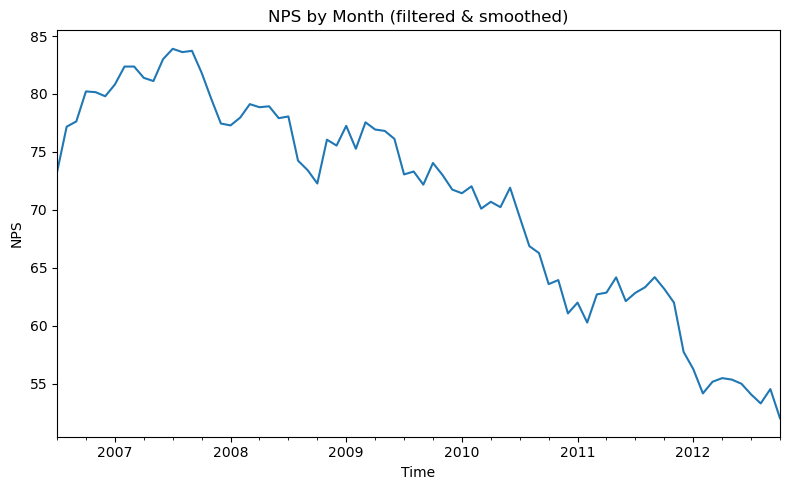

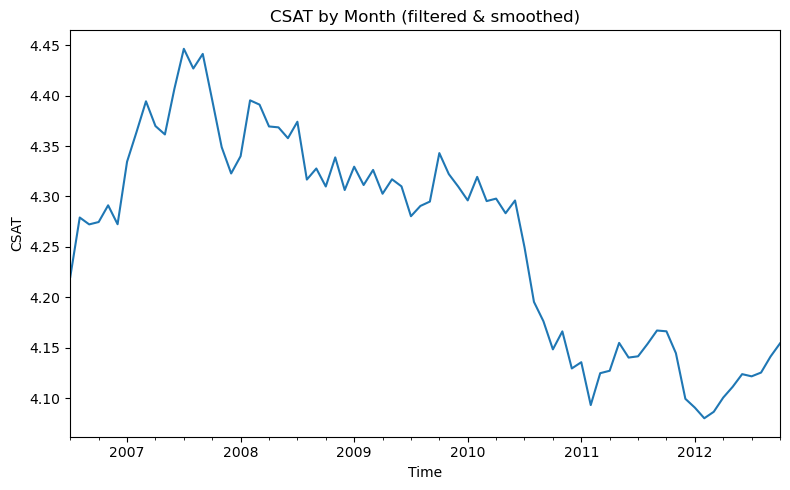


Top products by NPS:
ProductId
B001P05K8Q    100.0
B004M62D5S    100.0
B004FEN3GK    100.0
B004FEN3GA    100.0
B00954NYVY    100.0
B001P05K7M    100.0
B0043WOANY    100.0
B003QDRJXY    100.0
B003JA5KLM    100.0
B003FDG4K4    100.0
Name: NPS, dtype: float64

Bottom products by NPS:
ProductId
B006N3I69A   -97.628458
B000X1Q1G8   -79.084074
B004TJF3BE   -73.150685
B009RB4GO4   -70.786517
B0033HPPIO   -53.603874
B002NHYQAS   -50.000000
B005K4Q1RW   -48.201439
B004JRMG98   -48.073702
B000F6SNPS   -46.954315
B00141OU50   -43.105068
Name: NPS, dtype: float64


In [13]:
# Step 6: Visualize trends & product leaders/laggards
# Purpose:
#   - Quick visual QA before exporting to Tableau
#   - Show NPS/CSAT trends over time and identify top/bottom products

# 1 Time-series: monthly NPS and CSAT (already filtered & 3-mo smoothed in Step 3)
plot_series(metrics['nps_by_month'],  "NPS by Month (filtered & smoothed)", "NPS")
plot_series(metrics['csat_by_month'], "CSAT by Month (filtered & smoothed)", "CSAT")

# 2 Product ranking by NPS
top_n = 10

print("\nTop products by NPS:")
# Best-performing products (high loyalty)
print(metrics['nps_by_product'].sort_values(ascending=False).head(top_n))

print("\nBottom products by NPS:")
# Worst-performing products (priority for fixes)
print(metrics['nps_by_product'].sort_values(ascending=True).head(top_n))


## Summary

Back in 2006 to 2008, our NPS was very high — around 80 or above. Customers were loyal, and many of them were promoters. But after 2009, the trend started going down, and by 2012 NPS dropped close to 55. This means fewer customers are willing to recommend us.

Customer satisfaction shows the same story. The average score (CSAT) was about 4.4 out of 5 in 2007, but slowly dropped to around 4.1. So both loyalty and satisfaction are moving down together. This is a warning signal: something in the product or service is making customers less happy over time.

If we look at products, the contrast is very clear.
Some products are perfect — they have 100% NPS, meaning every reviewer was a promoter. These are our ‘hero products’. They can be used in marketing, and we can study why customers love them.

But at the same time, some products are very weak. One product had –97 NPS, meaning almost every review was negative. These weak products are dangerous: they not only lose sales, but also damage the brand image.

So the insight is: customers used to be very happy, but loyalty is falling. We must protect the products that people love, and fix or remove the products that make people unhappy.

In [15]:
#Step 7 Export metrics in tidy format for Tableau (Level, Month, ProductId, Metric, Value)
#Level → tells you if the metric is Overall, Monthly, or Product.
#Month → used only for trend analysis (time series).
#ProductId → used only for product ranking.
#Metric → NPS or CSAT.
#Value → numeric result.

rows = []

# Overall# Overall (single values for whole dataset)
rows.append({"Level":"Overall","Month":None,"ProductId":None,"Metric":"NPS","Value":metrics['NPS_overall']})
rows.append({"Level":"Overall","Month":None,"ProductId":None,"Metric":"CSAT","Value":metrics['CSAT_overall']})

# Monthly (trend over time)
for date, val in metrics['nps_by_month'].items():
    rows.append({"Level":"Monthly","Month":date,"ProductId":None,"Metric":"NPS","Value":val})
for date, val in metrics['csat_by_month'].items():
    rows.append({"Level":"Monthly","Month":date,"ProductId":None,"Metric":"CSAT","Value":val})

# Product-level (ranking by product ID)
for pid, val in metrics['nps_by_product'].items():
    rows.append({"Level":"Product","Month":None,"ProductId":pid,"Metric":"NPS","Value":val})
for pid, val in metrics['csat_by_product'].items():
    rows.append({"Level":"Product","Month":None,"ProductId":pid,"Metric":"CSAT","Value":val})

# Convert to DataFrame
voc_long = pd.DataFrame(rows)

# Save to CSV (ready for Tableau import)
voc_long.to_csv("VoC_metrics_long.csv", index=False)
print("Export complete: VoC_metrics_long.csv")


Export complete: VoC_metrics_long.csv


In [17]:
# Step 8: Export topics (Tableau-friendly) + auto theme naming
# Goal:
#   1) Flatten LDA topics into a long table: TopicId, Sentiment, Keyword, Count
#   2) Auto-name each Topic (Theme) using regex rules on its keyword set
#   3) Manually override theme names for storytelling polish
#   4) Export base and themed versions for Tableau

import re
import pandas as pd
from collections import defaultdict

# 1 Flatten topic objects into long rows 
topic_rows = []

def export_topics(topics, sentiment_label):
    """
    topics: [{'topic_id': int, 'keywords': [kw1, kw2, ...]}, ...]
    sentiment_label: "Detractor" or "Promoter"
    """
    for t in topics:
        tid = t['topic_id']
        for kw in t['keywords']:
            topic_rows.append({
                "TopicId": tid,
                "Sentiment": sentiment_label,  # Detractor or Promoter
                "Keyword": kw,
                "Count": 1  # placeholder count; can be replaced by real frequency
            })

# Assumes topics_det and topics_pro already computed in Step 5
export_topics(topics_det, "Detractor")
export_topics(topics_pro, "Promoter")

df_topics = pd.DataFrame(topic_rows)

# De-duplicate within a topic (in case of repeated keywords)
df_topics = (df_topics
             .groupby(["TopicId","Sentiment","Keyword"], as_index=False)["Count"]
             .sum())

# 2 Auto theme naming via regex rules 
RULES = [
    ("Packaging / Damage",  [r"package|packaging|box|seal|leak|broken|damaged|crushed|spill|seal(ed)?|dent"]),
    ("Delivery Speed / Shipping", [r"ship|shipping|delivery|late|delay|arrive|prime|courier|carrier"]),
    ("Refund / Return / Service", [r"refund|return|replace|customer service|support|warranty|contact|response"]),
    ("Price & Value", [r"price|expensive|cheap|value|worth|cost"]),
    ("Taste & Freshness", [r"taste|flavor|fresh|stale|smell|aroma|bad|rancid|rotten"]),
    ("Quality / Ingredients", [r"quality|ingredient|organic|natural|authentic|texture|consistency"]),
    ("Ease of Use / Preparation", [r"easy|hard|difficult|instruction|prepare|mix|open"]),
    ("Health / Effect", [r"healthy|diet|keto|gluten|sugar|allergy|reaction|benefit|effect"]),
    ("Portion / Size", [r"size|portion|ounce|bag|pack|serving|weight"]),
    ("Brand / Trust", [r"brand|trust|authentic|fake|counterfeit|label"]),
    # Promoter-positive clusters
    ("Delicious / Love", [r"delicious|tasty|yummy|love|great|amazing|awesome|perfect"]),
    ("Fast Delivery", [r"fast|quick|prompt|on time"]),
]

def auto_theme_for_keywords(keyword_list):
    """
    Score each rule by regex matches over the topic's keyword set; pick the highest.
    Fallback to 'General / Other' if no rules match.
    """
    score = defaultdict(int)
    joined = " ".join(keyword_list).lower()
    for theme, patterns in RULES:
        for pat in patterns:
            if re.search(pat, joined):
                score[theme] += 1
    if not score:
        return "General / Other"
    return max(score.items(), key=lambda x: x[1])[0]

# Aggregate keywords per (TopicId, Sentiment) to name themes
agg_kw = (df_topics.groupby(["TopicId","Sentiment"])["Keyword"]
          .apply(list).reset_index())
agg_kw["AutoTheme"] = agg_kw["Keyword"].apply(auto_theme_for_keywords)

# 3 Manual overrides (optional) 
# Use this to enforce business-friendly names for specific topics.
MANUAL_THEME_MAP = {
    # Example:
    # (3, "Detractor"): "Cold Chain / Freshness",
    # (2, "Promoter"):  "Great Taste & Quick Delivery",
}

def apply_manual_theme(row):
    key = (row["TopicId"], row["Sentiment"])
    return MANUAL_THEME_MAP.get(key, row["AutoTheme"])

agg_kw["Theme"] = agg_kw.apply(apply_manual_theme, axis=1)

# 4 Join themes back to keyword rows and export 
df_topics_themed = df_topics.merge(
    agg_kw[["TopicId","Sentiment","Theme"]],
    on=["TopicId","Sentiment"],
    how="left"
)

# Export both base and themed versions
df_topics.to_csv("VoC_topics.csv", index=False)
df_topics_themed.rename(columns={"Theme":"ThemeName"}).to_csv("VoC_topics_with_themes.csv", index=False)

print("Exported:")
print(" - VoC_topics.csv")
print(" - VoC_topics_with_themes.csv  (adds ThemeName for Tableau)")


Exported:
 - VoC_topics.csv
 - VoC_topics_with_themes.csv  (adds ThemeName for Tableau)
